### Linear regression example
A linear regression example, representing a relatively minimal example for how softcvi can be used.

### Imports

In [1]:
from functools import partial
from typing import ClassVar

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from flowjax.distributions import Normal
from flowjax.experimental.numpyro import sample
from flowjax.train import fit_to_variational_target
from flowjax.wrappers import non_trainable
from jaxtyping import Array, PRNGKeyArray

from pyronox.losses import SoftContrastiveEstimationLoss
from pyronox.program import AbstractProgram


### Define the model

In [2]:

class RegressionModel(AbstractProgram):
    sigma: float | int
    n_covariates: ClassVar[int] = 100
    n_obs: ClassVar[int] = 200
    x: Array

    def __init__(self, key: PRNGKeyArray):
        x = jr.normal(key, (self.n_obs, self.n_covariates))  # Generate toy data
        self.x = non_trainable(x)  # If needed mark inexact arrays as non_trainable
        self.sigma = 1

    def __call__(
        self,
        *,
        obs: dict[str, Array] | None = None,
    ):
        obs = obs["y"] if obs is not None else None

        beta = sample("beta", Normal(jnp.zeros(self.n_covariates)))
        bias = sample("bias", Normal())
        mu = self.x @ beta + bias
        sample("y", Normal(mu, self.sigma), obs=obs)


class RegressionGuide(AbstractProgram):
    beta: Normal
    bias: Normal

    def __init__(self):
        self.beta = Normal(jnp.zeros(RegressionModel.n_covariates))
        self.bias = Normal()

    def __call__(self, obs=None):  # Allow passing obs as losses support obs in guide
        sample("beta", self.beta)
        sample("bias", self.bias)

key, subkey = jr.split(jr.key(0))
model = RegressionModel(subkey)
guide = RegressionGuide()

### Generate toy data

In [3]:
key, subkey = jr.split(key)
latents = model.sample(subkey)
obs = {"y": latents.pop("y")}

### Fit posterior

In [4]:
loss = SoftContrastiveEstimationLoss(n_particles=4, alpha=0.75)
key, subkey=jr.split(key)
(model, guide), losses = fit_to_variational_target(
    key=subkey,
    dist=(model, guide),
    loss_fn=partial(loss, obs=obs),
    steps=1000,
    learning_rate=1e-2,
)

100%|██████████| 5000/5000 [00:48<00:00, 103.40it/s, loss=566]   


Text(0, 0.5, '$\\beta$ posterior mean')

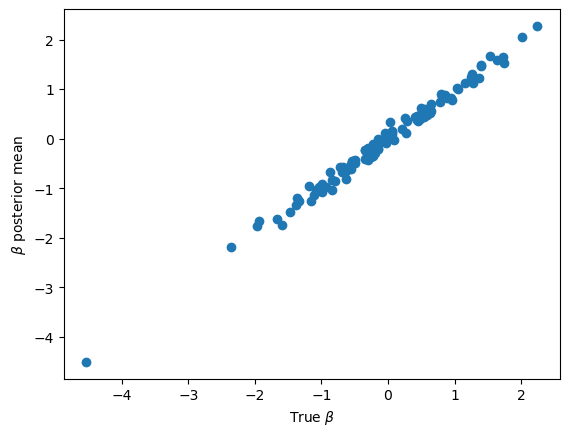

In [5]:
# Plot true coefficients against posterior means
plt.scatter(latents["beta"], guide.beta.loc)
plt.xlabel(r"True $\beta$")
plt.ylabel(r"$\beta$ posterior mean")
